# **Problem 1**


google collab link: https://colab.research.google.com/drive/155TdCXJxHunKuByI8kIaX_P-XQic0qLd


You must download the minst data set from git and upload it to your google drive:

https://github.com/jonPlante/IFT6135_Ass1



In [0]:
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# load data
with gzip.open('/content/gdrive/My Drive/mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

## Building the model

In [0]:
class NN(object):
    
    def __init__(self,Winitial,train_set,valid_set,test_set,LR,hidden_dims,n_hidden=2,mode='train'):
      self.train_set=train_set
      self.valid_set=valid_set
      self.test_set=test_set
      self.LR=LR
      self.dims=hidden_dims
      self.initialize_weights(Winitial,hidden_dims,len(self.train_set[0][0]),np.max(self.train_set[1])+1)
      self.reset_grad(len(self.train_set[0][0]))
      
             
    def initialize_weights(self,Winitial,dims,inputs,n_classes):
      if Winitial=='zero':
        self.W1=np.zeros((dims[0],inputs))
        self.W2=np.zeros((dims[1],dims[0]))
        self.W3=np.zeros((n_classes,dims[1]))
                
      elif Winitial=='normal':
        self.W1=np.random.normal(0,1,(dims[0],inputs))
        self.W2=np.random.normal(0,1,(dims[1],dims[0]))
        self.W3=np.random.normal(0,1,(n_classes,dims[1]))
        
      elif Winitial=='glarot':
        dl=np.sqrt(6/(dims[0]+inputs))
        self.W1=np.random.uniform(-dl,dl,(dims[0],inputs))
        dl=np.sqrt(6/(dims[1]+dims[0]))
        self.W2=np.random.uniform(-dl,dl,(dims[1],dims[0]))
        dl=np.sqrt(6/(n_classes+dims[1]))
        self.W3=np.random.uniform(-dl,dl,(n_classes,dims[1]))
        
        
      self.b1=np.zeros((dims[0],1))
      self.b2=np.zeros((dims[1],1))
      self.b3=np.zeros((n_classes,1))
      self.n_classes=n_classes
    def forward(self,input,label):
      self.oneHot=np.zeros((self.n_classes,1))
      self.oneHot[label]=1
      self.a1=np.dot(self.W1,input)+self.b1
      self.h1=self.activation_sig(self.a1)
      self.a2=np.dot(self.W2,self.h1)+self.b2
      self.h2=self.activation_sig(self.a2)
      self.a3=np.dot(self.W3,self.h2)+self.b3
      self.output=self.softmax(self.a3)
      self.L=self.loss(self.output,self.oneHot)
      
    
    def activation(self,input):
      #relu
      return np.maximum(0,input)
    def activation_sig(self,input):
      return 1/(1+np.exp(-input))
    
    def loss(self,predictions,onehot):
      return np.sum(-onehot*np.log(predictions))
    
    def softmax(self,input):
      input=input-np.max(input)
      return np.exp(input)/np.sum(np.exp(input))
    
    def reset_grad(self,inputs):
      self.gW3_MB=np.zeros((self.n_classes,self.dims[1]))
      self.gb3_MB=np.zeros((self.n_classes,1))
      self.gW2_MB=np.zeros((self.dims[1],self.dims[0]))
      self.gb2_MB=np.zeros((self.dims[1],1))
      self.gW1_MB=np.zeros((self.dims[0],inputs))
      self.gb1_MB=np.zeros((self.dims[0],1))
    
    def backward(self,input):
      self.go=-1/self.output*self.oneHot
      self.ga3=self.go[np.argmax(self.oneHot)]*(self.oneHot*self.output-self.output[np.argmax(self.oneHot)]*self.output)
      self.gW3=self.ga3*self.h2.reshape(1,-1)
      self.gb3=self.ga3
      self.gh2=np.dot(np.transpose(self.W3),self.ga3)
      self.ga2=self.gh2*self.h2*(1-self.h2)
      self.gW2=self.ga2*self.h1.reshape(1,-1)
      self.gb2=self.ga2
      self.gh1=np.dot(np.transpose(self.W2),self.ga2)
      self.ga1=self.gh1*self.h1*(1-self.h1)
      self.gW1=self.ga1*input.reshape(1,-1)
      self.gb1=self.ga1
                           
      self.gW3_MB+=self.gW3/self.MB_size
      self.gb3_MB+=self.gb3/self.MB_size
      self.gW2_MB+=self.gW2/self.MB_size
      self.gb2_MB+=self.gb2/self.MB_size
      self.gW1_MB+=self.gW1/self.MB_size
      self.gb1_MB+=self.gb1/self.MB_size
    
    def update(self):
      self.W1=self.W1-self.LR*self.gW1_MB
      self.b1=self.b1-self.LR*self.gb1_MB
      self.W2=self.W2-self.LR*self.gW2_MB
      self.b2=self.b2-self.LR*self.gb2_MB
      self.W3=self.W3-self.LR*self.gW3_MB
      self.b3=self.b3-self.LR*self.gb3_MB
    
    def train(self,epoch,MB):
      self.train_data=np.zeros((epoch+1,3))
      self.valid_data=np.zeros((epoch+1,3))
      self.reset_grad(len(self.train_set[0][0]))
      self.MB_size=MB
      Tot_Loss=0
      example_count=0
      print('Computing initial training error and loss')
      train_Loss, train_error=self.test(self.train_set[0],self.train_set[1])
      print('Initial training loss: ' +str(np.round(train_Loss,2))+', initial train error: '+str(np.round(train_error*100,2))+'%, initial train accuracy: '+str(np.round((1-train_error)*100,2))+'%')
      print('Computing initial validation error and loss')
      valid_Loss, valid_error=self.test(self.valid_set[0],self.valid_set[1])
      print('Initial validation loss: ' +str(np.round(valid_Loss,2))+', initial valid error: '+str(np.round(valid_error*100,2))+'%, initial validation accuracy: '+str(np.round((1-valid_error)*100,2))+'%')
      self.train_data[0,:]=[0,train_Loss,train_error]
      self.valid_data[0,:]=[0,valid_Loss,valid_error]
      for k in range(epoch):
        for j in range(len(self.train_set[0])):
          self.forward(np.array(self.train_set[0][j]).reshape(-1,1),self.train_set[1][j])
          self.backward(np.array(self.train_set[0][j]).reshape(-1,1))
          Tot_Loss+=self.L
          example_count+=1
          if j%MB==0 and not j==0:
            self.update()
            self.reset_grad(len(self.train_set[0][0]))
            
          if j%1000==0 and not j==0:
            print('\tLoss: '+str(np.round(Tot_Loss/example_count,3))+' '+str(np.round(j/len(self.train_set[0])*100,2))+'% of epoch ' +str(k+1)+' complete')
            Tot_Loss=0
            example_count=0
        print('Epoch: '+str(k+1) +' complete\n')
        print('Computing training error and loss')
        train_Loss, train_error=self.test(self.train_set[0],self.train_set[1])
        print('Training loss: ' +str(np.round(train_Loss,2))+', train error: '+str(np.round(train_error*100,2))+'%, train accuracy: '+str(np.round((1-train_error)*100,2))+'%')
        print('Computing validation error and loss')
        valid_Loss, valid_error=self.test(self.valid_set[0],self.valid_set[1])
        print('Validation loss: ' +str(np.round(valid_Loss,2))+', valid error: '+str(np.round(valid_error*100,2))+'%, validation accuracy: '+str(np.round((1-valid_error)*100,2))+'%')
        self.train_data[k+1,:]=[k+1,train_Loss,train_error]
        self.valid_data[k+1,:]=[k+1,valid_Loss,valid_error]
      
      test_Loss, test_error=self.test(self.test_set[0],self.test_set[1])
      print('\nTraining complete\nError on test set: '+str(np.round(test_error*100,2))+'%, Accuracy on test set: '+str(np.round((1-test_error)*100,2))+'%')
        
        
    
    def test(self,input,label):
      sumLoss=0
      incorrect=0
      for k in range(len(input)):
        self.forward(np.array(input[k]).reshape(-1,1),label[k])
        sumLoss+=self.L
        incorrect+=np.minimum(1,np.abs(label[k]-np.argmax(self.output)))
        if k%1000==0:
            print('\t'+str(np.round(k/len(input)*100,2))+'% of calc complete')
      return sumLoss/len(input), incorrect/len(input)
    
    def predict(self,input):
      a1=np.dot(self.W1,input)+self.b1
      h1=self.activation_sig(a1)
      a2=np.dot(self.W2,h1)+self.b2
      h2=self.activation_sig(a2)
      a3=np.dot(self.W3,h2)+self.b3
      output=self.softmax(a3)
      return np.argmax(output)
        
    
    



## **Initialization**

Number of hidden units in layer 1 is 520. Number of hidden units in layer 2 is 480.

The total set of parameters is 784x520+520+520x480+480+480x10+10=663 090 = 0.66309 M.

The activation is the sigmoid function. The learning rate is 0.05 and the minibatch size is 100.

Zero initialization

Computing initial training error and loss
	0.0% of calc complete
	2.0% of calc complete
	4.0% of calc complete
	6.0% of calc complete
	8.0% of calc complete
	10.0% of calc complete
	12.0% of calc complete
	14.0% of calc complete
	16.0% of calc complete
	18.0% of calc complete
	20.0% of calc complete
	22.0% of calc complete
	24.0% of calc complete
	26.0% of calc complete
	28.0% of calc complete
	30.0% of calc complete
	32.0% of calc complete
	34.0% of calc complete
	36.0% of calc complete
	38.0% of calc complete
	40.0% of calc complete
	42.0% of calc complete
	44.0% of calc complete
	46.0% of calc complete
	48.0% of calc complete
	50.0% of calc complete
	52.0% of calc complete
	54.0% of calc complete
	56.0% of calc complete
	58.0% of calc complete
	60.0% of calc complete
	62.0% of calc complete
	64.0% of calc complete
	66.0% of calc complete
	68.0% of calc complete
	70.0% of calc complete
	72.0% of calc complete
	74.0% of calc complete
	76.0% of calc complete
	78.0%

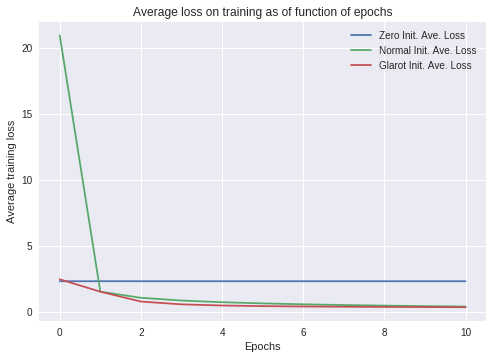

In [0]:
LR=0.05
dims=(520,480)
MB=100
epochs=10
print('Zero initialization\n')

NN_zero=NN('zero',train_set,valid_set,test_set,LR,dims)
NN_zero.train(epochs,MB)

print('Normal initialization\n')
NN_normal=NN('normal',train_set,valid_set,test_set,LR,dims)
NN_normal.train(epochs,MB)

print('Glarot initialization\n')
NN_glarot=NN('glarot',train_set,valid_set,test_set,LR,dims)
NN_glarot.train(epochs,MB)


print('\nPlotting results\n')
plt.plot(NN_zero.train_data[:,0],NN_zero.train_data[:,1],label='Zero Init. Ave. Loss')
plt.plot(NN_normal.train_data[:,0],NN_normal.train_data[:,1],label='Normal Init. Ave. Loss')
plt.plot(NN_glarot.train_data[:,0],NN_glarot.train_data[:,1],label='Glarot Init. Ave. Loss')
plt.title('Average loss on training as of function of epochs')
plt.xlabel('Epochs')
plt.ylabel('Average training loss')
plt.legend()
plt.show()

  


Plotting results



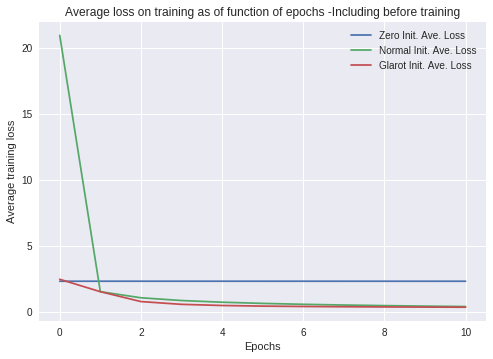


Plotting results



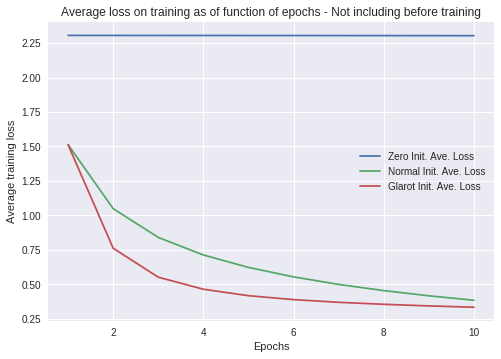

In [0]:
print('\nPlotting results\n')
plt.plot(NN_zero.train_data[:,0],NN_zero.train_data[:,1],label='Zero Init. Ave. Loss')
plt.plot(NN_normal.train_data[:,0],NN_normal.train_data[:,1],label='Normal Init. Ave. Loss')
plt.plot(NN_glarot.train_data[:,0],NN_glarot.train_data[:,1],label='Glarot Init. Ave. Loss')
plt.title('Average loss on training as of function of epochs -Including before training')
plt.xlabel('Epochs')
plt.ylabel('Average training loss')
plt.legend()
plt.show()

print('\nPlotting results\n')
plt.plot(NN_zero.train_data[1:,0],NN_zero.train_data[1:,1],label='Zero Init. Ave. Loss')
plt.plot(NN_normal.train_data[1:,0],NN_normal.train_data[1:,1],label='Normal Init. Ave. Loss')
plt.plot(NN_glarot.train_data[1:,0],NN_glarot.train_data[1:,1],label='Glarot Init. Ave. Loss')
plt.title('Average loss on training as of function of epochs - Not including before training')
plt.xlabel('Epochs')
plt.ylabel('Average training loss')
plt.legend()
plt.show()

As one can observe from the graphs above, when initializing the weights with the "zero" method, the training loss remains constant. This is natural since backpropagation cannot get through the hidden units, since we multiply the  last hidden layers gradient by the weights of zero which leads to zero gradient. The only parameters that can improve are the bias of the last layer.

We can also observe that when initializing with the "Normal" and "Glarot" methods, their is learning occuring since the average training loss diminishes. We observe that the the Glarot method diminishes training loss more rapidly and therefore is a better initialisation of the weights.

# **Hyperparameter search**

In [0]:
#try 1

LR=0.1
dims=(520,480)
MB=100
epochs=10

print('Glarot initialization\n')
NN_glarot=NN('glarot',train_set,valid_set,test_set,LR,dims)
NN_glarot.train(epochs,MB)

Glarot initialization

Computing initial training error and loss
	0.0% of calc complete
	2.0% of calc complete
	4.0% of calc complete
	6.0% of calc complete
	8.0% of calc complete
	10.0% of calc complete
	12.0% of calc complete
	14.0% of calc complete
	16.0% of calc complete
	18.0% of calc complete
	20.0% of calc complete
	22.0% of calc complete
	24.0% of calc complete
	26.0% of calc complete
	28.0% of calc complete
	30.0% of calc complete
	32.0% of calc complete
	34.0% of calc complete
	36.0% of calc complete
	38.0% of calc complete
	40.0% of calc complete
	42.0% of calc complete
	44.0% of calc complete
	46.0% of calc complete
	48.0% of calc complete
	50.0% of calc complete
	52.0% of calc complete
	54.0% of calc complete
	56.0% of calc complete
	58.0% of calc complete
	60.0% of calc complete
	62.0% of calc complete
	64.0% of calc complete
	66.0% of calc complete
	68.0% of calc complete
	70.0% of calc complete
	72.0% of calc complete
	74.0% of calc complete
	76.0% of calc complete
	78.

In [0]:
#try 2

LR=0.1
dims=(520,480)
MB=200
epochs=10

print('Glarot initialization\n')
NN_glarot=NN('glarot',train_set,valid_set,test_set,LR,dims)
NN_glarot.train(epochs,MB)

Glarot initialization

Computing initial training error and loss
	0.0% of calc complete
	2.0% of calc complete
	4.0% of calc complete
	6.0% of calc complete
	8.0% of calc complete
	10.0% of calc complete
	12.0% of calc complete
	14.0% of calc complete
	16.0% of calc complete
	18.0% of calc complete
	20.0% of calc complete
	22.0% of calc complete
	24.0% of calc complete
	26.0% of calc complete
	28.0% of calc complete
	30.0% of calc complete
	32.0% of calc complete
	34.0% of calc complete
	36.0% of calc complete
	38.0% of calc complete
	40.0% of calc complete
	42.0% of calc complete
	44.0% of calc complete
	46.0% of calc complete
	48.0% of calc complete
	50.0% of calc complete
	52.0% of calc complete
	54.0% of calc complete
	56.0% of calc complete
	58.0% of calc complete
	60.0% of calc complete
	62.0% of calc complete
	64.0% of calc complete
	66.0% of calc complete
	68.0% of calc complete
	70.0% of calc complete
	72.0% of calc complete
	74.0% of calc complete
	76.0% of calc complete
	78.

In [0]:
#try 3

LR=0.1
dims=(520,480)
MB=50
epochs=10

print('Glarot initialization\n')
NN_glarot=NN('glarot',train_set,valid_set,test_set,LR,dims)
NN_glarot.train(epochs,MB)

Glarot initialization

Computing initial training error and loss
	0.0% of calc complete
	2.0% of calc complete
	4.0% of calc complete
	6.0% of calc complete
	8.0% of calc complete
	10.0% of calc complete
	12.0% of calc complete
	14.0% of calc complete
	16.0% of calc complete
	18.0% of calc complete
	20.0% of calc complete
	22.0% of calc complete
	24.0% of calc complete
	26.0% of calc complete
	28.0% of calc complete
	30.0% of calc complete
	32.0% of calc complete
	34.0% of calc complete
	36.0% of calc complete
	38.0% of calc complete
	40.0% of calc complete
	42.0% of calc complete
	44.0% of calc complete
	46.0% of calc complete
	48.0% of calc complete
	50.0% of calc complete
	52.0% of calc complete
	54.0% of calc complete
	56.0% of calc complete
	58.0% of calc complete
	60.0% of calc complete
	62.0% of calc complete
	64.0% of calc complete
	66.0% of calc complete
	68.0% of calc complete
	70.0% of calc complete
	72.0% of calc complete
	74.0% of calc complete
	76.0% of calc complete
	78.

In [0]:
#try 4

LR=0.1
dims=(550,480)
MB=50
epochs=10

print('Glarot initialization\n')
NN_glarot=NN('glarot',train_set,valid_set,test_set,LR,dims)
NN_glarot.train(epochs,MB)

Glarot initialization

Computing initial training error and loss
	0.0% of calc complete
	2.0% of calc complete
	4.0% of calc complete
	6.0% of calc complete
	8.0% of calc complete
	10.0% of calc complete
	12.0% of calc complete
	14.0% of calc complete
	16.0% of calc complete
	18.0% of calc complete
	20.0% of calc complete
	22.0% of calc complete
	24.0% of calc complete
	26.0% of calc complete
	28.0% of calc complete
	30.0% of calc complete
	32.0% of calc complete
	34.0% of calc complete
	36.0% of calc complete
	38.0% of calc complete
	40.0% of calc complete
	42.0% of calc complete
	44.0% of calc complete
	46.0% of calc complete
	48.0% of calc complete
	50.0% of calc complete
	52.0% of calc complete
	54.0% of calc complete
	56.0% of calc complete
	58.0% of calc complete
	60.0% of calc complete
	62.0% of calc complete
	64.0% of calc complete
	66.0% of calc complete
	68.0% of calc complete
	70.0% of calc complete
	72.0% of calc complete
	74.0% of calc complete
	76.0% of calc complete
	78.

In [0]:
#try 5

LR=0.1
dims=(520,550)
MB=50
epochs=10

print('Glarot initialization\n')
NN_glarot=NN('glarot',train_set,valid_set,test_set,LR,dims)
NN_glarot.train(epochs,MB)

Glarot initialization

Computing initial training error and loss
	0.0% of calc complete
	2.0% of calc complete
	4.0% of calc complete
	6.0% of calc complete
	8.0% of calc complete
	10.0% of calc complete
	12.0% of calc complete
	14.0% of calc complete
	16.0% of calc complete
	18.0% of calc complete
	20.0% of calc complete
	22.0% of calc complete
	24.0% of calc complete
	26.0% of calc complete
	28.0% of calc complete
	30.0% of calc complete
	32.0% of calc complete
	34.0% of calc complete
	36.0% of calc complete
	38.0% of calc complete
	40.0% of calc complete
	42.0% of calc complete
	44.0% of calc complete
	46.0% of calc complete
	48.0% of calc complete
	50.0% of calc complete
	52.0% of calc complete
	54.0% of calc complete
	56.0% of calc complete
	58.0% of calc complete
	60.0% of calc complete
	62.0% of calc complete
	64.0% of calc complete
	66.0% of calc complete
	68.0% of calc complete
	70.0% of calc complete
	72.0% of calc complete
	74.0% of calc complete
	76.0% of calc complete
	78.

In [0]:
#try 6

LR=0.15
dims=(520,600)
MB=35
epochs=10

print('Glarot initialization\n')
NN_glarot=NN('glarot',train_set,valid_set,test_set,LR,dims)
NN_glarot.train(epochs,MB)

Glarot initialization

Computing initial training error and loss
	0.0% of calc complete
	2.0% of calc complete
	4.0% of calc complete
	6.0% of calc complete
	8.0% of calc complete
	10.0% of calc complete
	12.0% of calc complete
	14.0% of calc complete
	16.0% of calc complete
	18.0% of calc complete
	20.0% of calc complete
	22.0% of calc complete
	24.0% of calc complete
	26.0% of calc complete
	28.0% of calc complete
	30.0% of calc complete
	32.0% of calc complete
	34.0% of calc complete
	36.0% of calc complete
	38.0% of calc complete
	40.0% of calc complete
	42.0% of calc complete
	44.0% of calc complete
	46.0% of calc complete
	48.0% of calc complete
	50.0% of calc complete
	52.0% of calc complete
	54.0% of calc complete
	56.0% of calc complete
	58.0% of calc complete
	60.0% of calc complete
	62.0% of calc complete
	64.0% of calc complete
	66.0% of calc complete
	68.0% of calc complete
	70.0% of calc complete
	72.0% of calc complete
	74.0% of calc complete
	76.0% of calc complete
	78.

In [0]:
LR=0.30
dims=(520,600)
MB=20
epochs=10

print('Glarot initialization\n')
NN_glarot=NN('glarot',train_set,valid_set,test_set,LR,dims)
NN_glarot.train(epochs,MB)

Glarot initialization

Computing initial training error and loss
	0.0% of calc complete
	2.0% of calc complete
	4.0% of calc complete
	6.0% of calc complete
	8.0% of calc complete
	10.0% of calc complete
	12.0% of calc complete
	14.0% of calc complete
	16.0% of calc complete
	18.0% of calc complete
	20.0% of calc complete
	22.0% of calc complete
	24.0% of calc complete
	26.0% of calc complete
	28.0% of calc complete
	30.0% of calc complete
	32.0% of calc complete
	34.0% of calc complete
	36.0% of calc complete
	38.0% of calc complete
	40.0% of calc complete
	42.0% of calc complete
	44.0% of calc complete
	46.0% of calc complete
	48.0% of calc complete
	50.0% of calc complete
	52.0% of calc complete
	54.0% of calc complete
	56.0% of calc complete
	58.0% of calc complete
	60.0% of calc complete
	62.0% of calc complete
	64.0% of calc complete
	66.0% of calc complete
	68.0% of calc complete
	70.0% of calc complete
	72.0% of calc complete
	74.0% of calc complete
	76.0% of calc complete
	78.

An average of 97.06% accuracy on the validation set and an average of 96.97 % accuracy on the test set was observed with the following parameters:

Hidden units of layer 1: 520
Hidden units of layer 2: 600
Learning rate: 0.30
Mini batch size : 20
Nonlinearity used: sigmoid

The following table shows the hyperparamater search that was done:

![alt text](https://i.ibb.co/xz1Tyv4/Parameter-Search.png)




# **Validate gradients using finite different**

In [0]:
#get gradient for one training example
NN_glarot.forward(np.array(NN_glarot.train_set[0][0]).reshape(-1,1),NN_glarot.train_set[1][0])
NN_glarot.backward(np.array(NN_glarot.train_set[0][0]).reshape(-1,1))

noPoints=100
true_grad=NN_glarot.gW2[0,:10]
finite_grad=np.zeros((noPoints,10)) # values by parameters N*I
iValues=np.linspace(0,5,noPoints)
N=np.zeros(noPoints)
for i in range(noPoints):
  n=10**iValues[i]
  N[i]=n
  for j in range(10):
    weight=NN_glarot.W2[0,j]
    NN_glarot.W2[0,j]=weight+1/n
    NN_glarot.forward(np.array(NN_glarot.train_set[0][0]).reshape(-1,1),NN_glarot.train_set[1][0])
    loss1=NN_glarot.L
    NN_glarot.W2[0,j]=weight-1/n
    NN_glarot.forward(np.array(NN_glarot.train_set[0][0]).reshape(-1,1),NN_glarot.train_set[1][0])
    loss2=NN_glarot.L
    NN_glarot.W2[0,j]=weight
    finite_grad[i,j]=(loss1-loss2)/(2*1/n)

print("done")

done



Plotting results



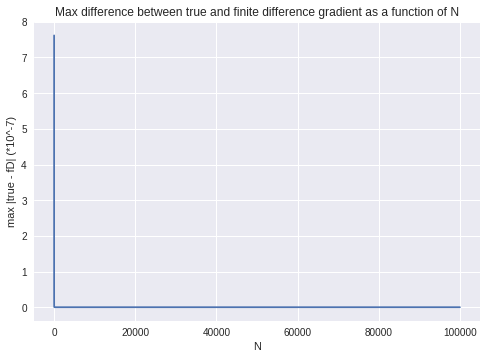

In [0]:
maxDiff=np.amax(np.abs(finite_grad-true_grad),axis=1)
maxDiff=maxDiff/(10**(-7))
print('\nPlotting results\n')
plt.plot(N,maxDiff)
plt.title('Max difference between true and finite difference gradient as a function of N')
plt.xlabel('N')
plt.ylabel('max |true - fD| (*10^-7)')
plt.show()

We can see from the figure above that when N gets bigger, the difference between the true gradient and finite difference gradient decreases. We also observe that the difference for both gradients is extremely small (10^-7). This is a sign that the Neural Net has converged. If we had done this before training the neural net, the difference would be much greater.